<font color=blue> 
        
❗Before starting, make sure **hw2_data.pgz** and **images_5_classes.tar.gz** are in the same directory as your notebook.<br>
❗Run the below cell to unzip the data. (Needed for displaying images in "HW2 Description".)

In [1]:
%%capture
import os
if not os.path.isdir('images_5_classes'): 
    !tar -xvzf images_5_classes.tar.gz

# HW2 Description

In this homework assignment, we are working with instagram photos of **five national parks**. The task is to train up a classifier that correctly predicts the park given a photo. This is a non-trivial task, since the naive approach (using each pixel as a feature) will fail. To see why consider the two photos below.

| Arches 1| Arches 2 |
|-|-|
|![](./images_5_classes/archesnationalpark/2_1342855034455221159.jpg)|![](./images_5_classes/archesnationalpark/2_1343181954723713884.jpg)|

Landmarks occur in both photos but not in the same position in either image. Further, due to the opening in the arch, the middle of the photo may be occupied by sky or alternatively by rock. At best, treating pixels as features we can analyze the images in terms of color frequencies (i.e. the intensities of the red, green, and blue channels).

Instead of naively using each pixel as a feature, we will provide you with **precomputed feature vectors**, computed by a neural network known as **AlexNet**. These features provide aggregated information about edges, shapes, and color intensities across each image. 

Hence, your task is to train a prediction model which takes as input distilled representations of the photos (the 1000-dimensional feature vectors provided by AlexNet) and predicts where (one of the five National Parks) the photo was taken. 


In [2]:
import gzip
import numpy as np
from __future__ import print_function
try:
    import cPickle as pickle
    kwargs = {}
except:
    import _pickle as pickle
    kwargs = {'encoding':'bytes'}

features, labels, sample_ids, label_names =  pickle.load( gzip.open('hw2_data.pgz', 
                                                                    'rb'), **kwargs )
print('IDs and the corresponding national parks:')
print(label_names)

IDs and the corresponding national parks:
{0: b'greatsanddunesnationalpark', 1: b'petrifiedforestnationalpark', 2: b'archesnationalpark', 3: b'congareenationalpark', 4: b'katmainationalpark'}


In [3]:
import numpy as np
np.random.seed(12345)
N = features.shape[0]
arr = np.arange(N)
np.random.shuffle(arr)
train_num = int(round(N*0.8))
test_num = features.shape[0]-train_num

train_subset = arr[:train_num]
train_features = features[train_subset,:]
train_labels = labels[train_subset]
train_sample_ids = [sample_ids[i] for i in train_subset]

test_subset = arr[train_num:]
test_features = features[test_subset,:]
test_labels = labels[test_subset]
test_sample_ids = [sample_ids[i] for i in test_subset]
print("Dataset split into {} training and {} test examples.".format(train_num,test_num))

Dataset split into 403 training and 101 test examples.


# The plan:

We will model features of the dataset using **<span style='background: greenyellow'> Bayesian networks</span>**, one network for each of the five classses (National Parks). Specifically, we will be using <span style='background: greenyellow'>Bayesian trees</span>. <br><br>
$$
p(\mathbf{x} \mid h=c) = \prod_{(j,k) \in \textrm{Edges}^c} p(x_j \mid x_k,\theta_{j}^c)
$$
where $\textrm{Edges}^c$ is the edge set describing the tree for class $c$ and $\theta_{j}^c$ are parameters for conditional probability of $x_j$ given its parent $x_k$. <span style='background: greenyellow'>*Note that different classes will correspond to different trees and use different parameters!*</span>

### The tasks we will have to accomplish are:
1. <a href='#1.-Learning-a-tree-structure-(1pt)'>Implement learning of the tree structure for each class using Chow-Liu algorithm (**1pt**) </a>
2. <a href='#2.-Learning-parameters-of-a-tree-structured-Bayes-net-(3pt)'>Learn parameters for conditional probabilities associated with edges in these trees (**3pts**)</a>
3. <a href="#3.-Compute-probability-of-a-feature-vector-x-given-a-Bayes-net's-structure-and-parameters-(2pt)">Compute probability of a feature vector $\mathbf{x}$ in each of the five Bayesian networks (**2pt**) </a>
4. <a href='#4.-Compute-probabilities-that-a-feature-vector-x-belongs-to-each-class-(2pt)'>Compute probabilities that the feature vector $\mathbf{x}$  belongs to each class (**2pt**) </a>
5. <a href='#5.-Make-predictions-based-on-probabilities-(1pt)'>Make predictions based on probabilities (**1pt**)</a>
6. <a href='#6.-Explore-prediction-performance-(1pt)'>Explore prediction performance (**1pt**) </a>

### Variable/function definitions for the code aspect of this homework: 
|Variable Name | Meaning |
|-|-|
| {```train```&#124;```test```}```features``` | Matrix of features of photos |
| {```train```&#124;```test```}```labels```  | Vector of labels of photos |
| {```train```&#124;```test```}```sample_ids``` | List of ids for each sample (filenames) |
| ```label_names``` | Names of classes (list of strings) |
| ```class_edges``` | Dictionary of edge lists. One edge list per class |
| ```class_thetas``` | Dictionary of parameters. One theta per class |

| Function name | Purpose |
|-|-|
|```corr``` | Computes Pearson correlation between two vectors. |
| ```mutual_information``` | Computes mutual information between two vectors. |
|```mutual_info_all```| Compute mutual information between columns of  a matrix. |
|```chowliu``` | Chow-Liu algorithm on a feature matrix. <br>Returns adjacency matrix; non-zero entry indicates edge. |
|```get_edge_list``` | Creates an edge list from adjacency matrix. <br>Each edge represented by (parent,child) element. |
|```get_label_subsets``` | Get sample indices for each class. Returns a dictionary of lists. <br \>Key is class label $c$, value is sample indices for that class |
|```get_edges_for_each_class```| Produces an edge list for each class. Returns a dictionary of lists.<br>Key is class label $c$, value is edge set for that class $\textrm{Edges}^c$|
|```get_thetas_for_each_class```| Learns parameters for each class. Returns a dictionary of matrices. <br>Key is class label $c$, value is matrix $\theta^c$.| 
|```p_h_given_x_theta```| Computes probability that particular sample $x$ came from a class $h$ <br>given all the class edge sets and parameters. Uses Bayes rule.|

<hr style="border:4px solid blue"> </hr>
<hr style="border:4px solid blue"> </hr>

# 1. Learning a tree structure  <span style='background :yellow' > (1pt)




<hr style="border:2px solid deepskyblue"> </hr>

### 1a) Computing mutual information

Chow-Liu structure learning algorithm uses **<span style='background :greenyellow'>mutual information</span>** to find the best tree. In class, we specified how to compute mutual information between variables distributed according to a categorical distribution. If we assume that the variables are **Gaussian**, then mutual information is given 
by

$$ 
I(X,Y) = -\frac{1}{2} \ln(1-Corr(X, Y)^2) 
$$
where *Corr* denotes <span style='background :greenyellow'>**Pearson correlation**</span>.
<br>


<font color=blue> **ToDo**
* Implement mutual information computation in the function ```mutual_information```. 
    (Hint: Use the ```corr``` function we have provided.)
* Implement the function ```mutual_info_all``` which computes mutual information between all features (columns) in a matrix. 

In [4]:
from scipy.stats import entropy

In [5]:
def corr(x,y):
    if x.shape[0] == 0:
        rowvar = 1
    else:
        rowvar = 0
    return np.corrcoef(np.asarray(x),np.asarray(y),rowvar = rowvar)[0,1]

def mutual_information(x,y):
    return -0.5*np.log(1-corr(x,y)**2)    ## FILL-IN-THE-BLANK ##

def mutual_info_all(M):
    f_num = M.shape[1] # number of features
    mi_ary = np.zeros( (f_num, f_num) )
    for i in range(f_num):           ## FILL-IN-THE-BLANK ##
        for j in range(i+1,f_num):       ## FILL-IN-THE-BLANK ##
            mi_ary[i,j] = mutual_information(M[:,i], M[:,j])           ## FILL-IN-THE-BLANK ##
    return mi_ary

np.random.seed(1)
x = np.random.randn(10)
y = x + 0.01*np.random.randn(10)
z = -x + 0.01*np.random.randn(10)

print(("Mutual information {:1.3f} between variables "+
      "with correlation {:1.3f}.").format(mutual_information(x,y),corr(x,y)))
print(("Mutual information {:1.3f} between variables "+
      "with correlation {:1.3f}.").format(mutual_information(x,z),corr(x,z)))
features = np.asmatrix([x,y,z]).transpose()
MI = mutual_info_all(features)

print(MI,("\nMI(x,z) = {:1.3f} should be larger " + 
       "than MI(y,z) = {:1.3f}.").format(MI[0,2],MI[1,2]))
assert(MI[0,2]>MI[1,2])

Mutual information 5.067 between variables with correlation 1.000.
Mutual information 5.037 between variables with correlation -1.000.
[[0.         5.06715848 5.03662491]
 [0.         0.         4.79462788]
 [0.         0.         0.        ]] 
MI(x,z) = 5.037 should be larger than MI(y,z) = 4.795.


✅ If you did everything correctly, highly correlated variables,```x``` and ```y```, should have **high** mutual information. <br>
✅ Similarly highly anti-correlated variables,  ```z``` and ```x```, should have **high** mutual information.

<hr style="border:2px solid deepskyblue"> </hr>

### 1b) Chow-Liu tree algorithm

Given a feature matrix, the matrix of mutual information (denoted as ```M```) between features, pairwise, provides <span style='background :greenyellow'> weights for each candidate edge</span> in a Bayesian network. Running the **<span style='background :greenyellow'>maximum spanning tree</span>** algorithm on this weight matrix yields optimal connectivity structure of the graph. 

<font color=blue> **ToDo** *(In order to implement the Chow-Liu algorithm, you will need to do the following... )*

* Compute mutual information between columns (features).
* Compute maximum spanning tree on mutual information matrix. 
     [Hint: Use ```scipy```'s implementation of ***minimum*** spanning tree on matrix of ***negative*** mutual information.]

In [6]:
from scipy.sparse.csgraph import minimum_spanning_tree
def chowliu(features):
    mutinfo = mutual_info_all(features)    ## FILL-IN-THE-BLANK ##
    adjacency_matrix = minimum_spanning_tree(-mutinfo)    ## FILL-IN-THE-BLANK ##
    return adjacency_matrix

def get_edge_list(mat):
    f_num = mat.shape[0]
    edges = []
    for k in range(f_num):
        lst = np.nonzero(mat[k,:])[1]
        # k is parent, j is child
        new_edges = [(k,j) for j in lst]        
        edges.extend(new_edges)
    return edges
        
np.random.seed(1)
x = np.random.randn(20)
y = x + 0.1*np.random.randn(20)
z = -x + 0.1*np.random.randn(20)
q = z + 0.1*np.random.randn(20)
w = y + 0.1*np.random.rand(20)
features = np.asmatrix([x,y,z,q,w]).transpose()
adjacency = chowliu(features)
names = ['x','y','z','q','w']
edges = get_edge_list(adjacency)
print('Edge list: ',[(names[i] + '->' + names[j]) for (i,j) in edges])

edges = get_edge_list(adjacency)

assert(set(edges)== set([(0, 1), (0, 2), (1, 4), (2, 3)]))

Edge list:  ['x->y', 'x->z', 'y->w', 'z->q']


#### ✅ Sanity check for tree building implementation

  Edge pairs between ```x,y,z,q,w``` should reflect the dependencies of variables in the code.

Since  
```pyhon
y = x + 0.1*np.random.randn(20)
```
```y``` is a noisy version of ```x``` and we expect to have an edge ```x->y```. Similarly, since
```
w = y + 0.1*np.random.rand(20)
```
```w``` is a noisy version of ```y``` and we expect
to see edges ```y->w```.



If you did everything correctly. You should output an edge list as follows...

```Edge list: ['x->y', 'x->z', 'y->w', 'z->q']```

... also, the ```assert``` should pass.

<hr style="border:2px solid deepskyblue"> </hr>

### 1c) Learning class-specific trees

We need to train a Bayesian tree for *each* class! <br>

<br>
<font color=blue> 
    
**ToDo**
* Split training data into class-specific data matrices.
* Run the Chow-Liu tree algorithm on class-specific data subsets and obtain resulting edge lists.
* Store resulting edge lists, one per class, in the dictionary ```class_edges```.

In [7]:
def get_label_subsets(train_labels):
    label_set = np.unique(train_labels) #get 5 label numbers
    label_sample_map = {} #a label to sample index map
    for label in label_set:        ## FILL-IN-THE-BLANK ##
        label_sample_map[label] =  np.where(train_labels == label)       ## FILL-IN-THE-BLANK ##
    return label_sample_map
        
def get_edges_for_each_class(train_features, train_labels):
    label_set = np.unique(train_labels) #get 5 label numbers
    label_sample_map = get_label_subsets(train_labels)    
    class_edges = {}
    for label in label_sample_map:         ## FILL-IN-THE-BLANK ##
        adjacency = chowliu(train_features[label_sample_map[label],:])         ## FILL-IN-THE-BLANK ##
        class_edges[label] = get_edge_list(adjacency)      ## FILL-IN-THE-BLANK ##
    return class_edges
    
class_edges = get_edges_for_each_class(train_features, train_labels)
%time

Wall time: 0 ns


<a href="#The-plan:">top</a>

<hr style="border:4px solid blue"> </hr>
<hr style="border:4px solid blue"> </hr>

# 2. Learning parameters of a tree-structured Bayes net <span style='background :yellow' > (3pt)
</span>

Given a tree structure, we can write out the log-likelihood for a Bayes net. In a tree, a node has at most one parent.

We will denote the set of edges in a tree as Edges. Hence if node $k$ is parent of node $j$ then the pair $(j,k)$ will be in the set Edges. *Note that if edge is $(j,k)$ is in the set Edges, then $(k,j)$ will not be.* We will denote the node that has no parents (the **root** node) as $r$.

Log-likelihood is given by
$$
\begin{aligned}
LL(\Theta) &= \underbrace{\sum_{i=1}^N}_{\textrm{samples}}\left[ \sum_{(j,k) \in \textrm{Edges}} \log p(x_{i,j} \mid x_{i,k},\theta_{j}) + \log p(x_{i,r}\mid\theta_{r})\right]\\
&= \sum_{(j,k) \in \textrm{Edges}} \sum_{i=1}^N\log p(x_{i,j} \mid x_{i,k},\theta_{j}) + \sum_{i=1}^N\log p(x_{i,r}\mid\theta_{r}) 
\end{aligned}.\tag{1}
$$

Since $\theta_{j}$ only appears only in terms involving edge $(j,k)$ we can eliminate other terms and obtain  optimal $\theta_{j}$ as
$$
\theta_j^* = \mathop{\textrm{argmax}}_{\theta_j}\sum_{i=1}^N\log p(x_{i,j} \mid x_{i,k},\theta_{j}).
$$
Similarly, the optimal $\theta_{r}$ is given by
$$
\theta_r^* = \mathop{\textrm{argmax}}_{\theta_r}\sum_{i=1}^N\log p(x_{i,r} \mid \theta_r).
$$
Put succinctly, all of these optimization problems can be <span style='background :greenyellow'> solved separately</span>.


<hr style="border:2px solid deepskyblue"> </hr>

### 2a) Parameter learning

We need to specify how the child variables depend on their parents. Since our features are continuous, we will assume that the conditional probabilities $p(x_j \mid x_k)$ are Gaussian. Each feature will be modeled as a <span style='background :greenyellow'> linear function of its parent</span> with a bias contribution. Since root does not have a parent, it will have just a bias parameter.

Specifically,
$$
\begin{aligned}
x_j &\mid x_k,\theta_j \sim \mathcal{N}(\theta_{j,0} + \theta_{j,1}x_k,\sigma^2) \\
x_r &\mid \theta_r \sim \mathcal{N}(\theta_{r,0},\sigma^2)
\end{aligned}
$$

Log conditional probabilities are given by
$$
\begin{aligned}
\log p(x_j\mid x_k,\theta_j) &= -\log 2\pi \sigma^2 -  \frac{1}{2\sigma^2}(x_j - \theta_{j,0} - \theta_{j,1}x_{k})^2\\
\log p(x_r\mid \theta_r) &= -\log 2\pi \sigma^2 -  \frac{1}{2\sigma^2}(x_j - \theta_{r,0} )^2
\end{aligned}
$$
<br>
Hence, terms in log-likelihood (Eq.1) involving $\theta_j$ are
$$
\sum_{i=1}^N \left[-\log 2\pi \sigma^2 -  \frac{1}{2\sigma^2}(x_{i,j} - \theta_{j,0} - \theta_{j,1}x_{i,k})^2 \right] \tag{2}
$$
and  terms involving $\theta_r$ are
$$
\sum_{i=1}^N \left[-\log 2\pi \sigma^2 -  \frac{1}{2\sigma^2}(x_{i,r} - \theta_{r,0} )^2 \right]  \tag{3}.
$$ 

In order to obtain optimal parameters for the model <span style='background :greenyellow'> we will maximize Eq. 2 and Eq. 3 with regard to parameters $\theta$. </span>

***We will not obtain a closed form solution for $\theta_{j,0}$ nor $\theta_{j,1}$!*** Rather, we will <span style='background :greenyellow'> iterate updates </span> which fix $\theta_{j,0}$ to get best $\theta_{j,1}$ and then fix $\theta_{j,1}$ to get best $\theta_{j,0}$. This approach is called **<span style='background :greenyellow'>coordinate ascent</span>**. 

<br> 
<font color=blue>

**ToDo**

* Take derivatives of the Eq. 2 and Eq. 3 above with respect to $\theta_j$ and $\theta_r$. Then, equate those derivatives to zero and solve for $\theta_{j,0},\theta_{j,1}$ and $\theta_{r,0}$. 
    <br>

$$ \large
\begin{aligned}
\theta^*_{j,0} &= \frac{\sum_{i=1}^N (x_{i,j} - \theta_{j,1}x_{i,k})}{N}\\\\
\theta^*_{j,1} &= \sum_{i=1}^N \frac{ x_{i,j}x_{i,k} - \theta_{j,0}x_{i,k}}{x_{i,k}^2}\\\\
\theta^*_{r,0} &= \frac{\sum_{i=1}^N x_{i,r}}{N}\\\\
\end{aligned}
$$
<font color=black>
    
 * Note that  $\theta^*_{j,0}$ depends on $\theta_{j,1}$ and vice versa. This suggests that we need to *iterate* these updates until there is no more change in either variable! However $\theta_{r,0}$ can be solved in a *single* update.

<br>
<br> 
<font color=blue>

* Implement function that finds optimal $\theta_j$ given vectors $x_j$ and $x_k$. 
<br>   
* Implement function that finds optimal $\theta_r$ given vector of $x_r$. Our code assumes that r=0. 

In [8]:
#update for 𝜃_{r,0}, r is the root_index (0 in our case)
def compute_theta_r( x ):
    return sum(x[:,0]) / x.shape[0] ## FILL-IN-THE-BLANK ##

In [9]:
#update for 𝜃_{j, 0}, for link between j and k given 𝜃_j_1. 
#k is parent, j is child
def compute_theta_j_k_0( j, k, x, theta_j_1 ):
    return (sum(x[:,j]) - theta_j_1*sum(x[:,k])) / x.shape[0] ## FILL-IN-THE-BLANK ##

In [10]:
#update for 𝜃_{j, 1}, for link between j and k given 𝜃_j_0. 
#k is parent, j is child
def compute_theta_j_k_1( j, k, x, theta_j_0 ):
    return (sum(x[:,j]*x[:,k]) - theta_j_0*sum(x[:,k])) / sum(x[:,k]**2) ## FILL-IN-THE-BLANK ##

✅ In the below code, we will check that the code you wrote accurately estimates $\theta_r$ and $\theta_j$s. The true parameters are $\theta_r = 1.0$, $\theta_{1,0} = 0.5$ and $\theta_{1,1} = 2.0$. 

In [11]:
d = 1000
x = np.zeros((d,2))
x[:,0] = 1.0 + np.random.randn(d,)
x[:,1] = 0.5 + 2.0*x[:,0] + np.random.randn(d,)
theta_j = [0.0,0.0]

theta_r = compute_theta_r( x )
for it in range(40):
    theta_j[0] = compute_theta_j_k_0( 1, 0, x, theta_j[1] )
    theta_j[1] = compute_theta_j_k_1( 1, 0, x, theta_j[0])
print("theta_r_0:{} theta_j:{}".format(theta_r,theta_j))    
assert(abs(theta_r - 1.0)<0.1)
assert(abs(theta_j[0] - 0.5)<0.1)
assert(abs(theta_j[1] - 2.0)<0.1)

theta_r_0:1.0333542751510454 theta_j:[0.4950430649417722, 2.024316231736055]


<hr style="border:2px solid deepskyblue"> </hr>

### 2b)  Training the model
Compute $\theta^*_j$ and $\theta^*_r$ for each class.

In [12]:
def get_thetas_for_each_class(train_features, train_labels, class_edges):
    label_sample_map = get_label_subsets(train_labels)
    label_set = np.unique(train_labels)
    class_thetas = {}
    f_num = train_features.shape[1]
    for lab in label_set:
        print( 'processing class label {}'.format(lab) )
        c_samples = train_features[label_sample_map[lab]]    ## FILL-IN-THE-BLANK ##         # past was ,:]
        theta_r = compute_theta_r( c_samples )   ## FILL-IN-THE-BLANK ##
        c_edge_list= class_edges[lab]      ## FILL-IN-THE-BLANK ##
        thetas = np.zeros((f_num,2)) #the first column is j_0, and the second column is  j_1
        #the first row (thetas[0,:]) is for 𝜃_r

        for (k,j) in c_edge_list:        
            theta_j_1 = 0
            # do coordinate ascent using compute_theta_j_k_0 and compute_theta_j_k_1
            for z in range(400):                      ## FILL-IN-THE-BLANK ##
                theta_j_0 = compute_theta_j_k_0( j, k, c_samples, theta_j_1 )                        ## FILL-IN-THE-BLANK ##
                theta_j_1 = compute_theta_j_k_1( j, k, c_samples, theta_j_0 )                        ## FILL-IN-THE-BLANK ##
            #set the optimal 𝜃_j_0 and 𝜃_j_1 for this the edge (k, j)
            thetas[j, 0] = theta_j_0             ## FILL-IN-THE-BLANK ##
            thetas[j, 1] = theta_j_1             ## FILL-IN-THE-BLANK ##
        thetas[0,0] = theta_r   
        thetas[0,1] = np.nan # root has no parents
        class_thetas[lab] = thetas
    return class_thetas

class_thetas = get_thetas_for_each_class(train_features,train_labels,class_edges)

processing class label 0
processing class label 1
processing class label 2
processing class label 3
processing class label 4


<a href="#The-plan:">top</a>

<hr style="border:4px solid blue"> </hr>
<hr style="border:4px solid blue"> </hr>

# 3. Compute probability of a feature vector x given a Bayes net's structure and parameters <span style='background :yellow' > (2pt)

<font color=blue> 
<br> 
    
**ToDo** 
    
* Implement function that computes $\log p(x_j\mid x_k,\theta_j)$ for specific edge using optimal $\theta^*_j$. 
* Implement a function that computes $\log p(x_r\mid \theta_r)$ using optimal $\theta^*_r$ 


In [13]:
# Compute log p(x_j|x_k, 𝜃_j), for the edge between j and k, given 𝜃_{j, 0} and 𝜃_{j,1}
# Let sigma^2 = 1
def compute_lp_j_k( j, k, x, theta_j_0, theta_j_1 ):
    return -np.log(2*np.pi*1) - (1/2)*(x[j] - theta_j_0 - theta_j_1*x[k])**2    ## FILL-IN-THE-BLANK ##
    #return -np.log(2*np.pi*1)*len(x) - (1/2)*(sum(x - theta_j_0 - theta_j_1*x))**2 
# compute log p(x_r|𝜃_r), for the root node, given 𝜃_r. 
def compute_lp_r( x, theta_r ):
    
    return -np.log(2*np.pi*1) - (1/2)*(x[0] - theta_r)**2
    #return -np.log(2*np.pi*1)*len(x) - (1/2)*sum(x - theta_r)**2
    
    
    
    #return -np.log(2*np.pi*1)*x.shape[0] - (1/2)*sum(x[:,0] - theta_r)**2    ## FILL-IN-THE-BLANK ##

<font color=blue> 

**ToDo** 

* Implement a function that computes the log-probability of a sample $\mathbf{x}$ given a Root, Edges, and $\Theta$
</font>
    $$
\log p(\mathbf{x} \mid \Theta^*) = \sum_{r \in \textrm{Roots}} \log p(x_r \mid \theta^*_r) + \sum_{(j,k) \in \textrm{Edges}} \log p(x_j \mid x_k, \theta^*_{j})
$$

In [14]:
def compute_lp_x_given_Theta( x, thetas, edges):
    lp = compute_lp_r( x, thetas[0,0] )    ## FILL-IN-THE-BLANK ##  #thetas[0,0]  
    for (k,j) in edges:  
        # k is parent, j is child
        lp = lp + compute_lp_j_k( j, k, x, thetas[j, 0], thetas[j, 1])                ## FILL-IN-THE-BLANK ##
    return lp

<a href="#The-plan:">top</a>

<hr style="border:4px solid blue"> </hr>
<hr style="border:4px solid blue"> </hr>

# 4. Compute probabilities that a feature vector x belongs to each class <span style='background :yellow' > (2pt)
Tree-augmented Naive Bayes uses following model
$$
\begin{aligned}
p(h = c) &= \pi_c\\
p(\mathbf{x} \mid \Theta, h) &= p(\mathbf{x} \mid \Theta_c) \\
\end{aligned}
$$
<br>
where $\Theta_c$ are parameters of the Bayes net for feature vector $\mathbf{x}$ trained on class $c$.
<br>
<br>
<font color=blue>

**ToDo** <br>
* Use Bayes rule to express the posterior probability of class $c$ given the data $\mathbf{x}$ and model parameters $\theta$.
    <br><br>
    
$$ \large
p(h = c | \mathbf{x},\Theta) = \frac{ p(x | h = c, \Theta)p(h = c | \Theta) }{ \sum_{d}^{|C|=5} p(x | h = d, \Theta)p(h = d | \Theta) } \\\\
$$
    <br>
* Implement a function that takes as input $\Theta$ and a sample $\mathbf{x}$ and computes $p(h\mid\mathbf{x},\Theta)$. This function will use the expression you derived above. <font color=black>
 * Note that ```compute_lp_x_given_Theta``` computes log-probabilty of $\mathbf{x}$ for a class-specific tree, $\log p(\mathbf{x}\mid h=c,\Theta)$. Below, we provide code that computes $\log p(h)$. You just need to put together these pieces of code, making sure to use ```logsumexp``` appropriately.

In [15]:
def get_log_p_h(train_labels):
    label_set = np.unique(train_labels)
    log_p_h = np.zeros(len(np.unique(labels)))
    for i in label_set:
        count = len(np.nonzero(train_labels==i)[0])
        log_p_h[i] = np.log( float(count) / float(len(train_labels) ) )
    return log_p_h

log_p_h = get_log_p_h(train_labels)

def logsumexp(vec):
    m = np.max(vec,axis=0)   
    return np.log(np.sum(np.exp(vec-m),axis=0))+m

def p_h_given_x_theta( x, class_edges, class_thetas, log_p_h ):
    
    C = len(class_thetas)
    lognumerator = np.zeros(C)
    
    # implement Bayes rule here
    # compute log-numerators first and then normalize using logsumexp
    for i in range(C): 
        edges = class_edges[i]
        thetas = class_thetas[i]        
        lognumerator[i] = compute_lp_x_given_Theta(x, thetas, edges) + log_p_h[i]    ## FILL-IN-THE-BLANK ## [i]
    
    # use logsumexp to compute denominator
    logdenominator = logsumexp(lognumerator)                                         ## FILL-IN-THE-BLANK ##
    print(1, lognumerator, 2, logdenominator, 3)
    probs = np.exp(lognumerator - logdenominator)                                                  ## FILL-IN-THE-BLANK ##
    
    print("probs:",probs)
    assert(np.all(probs >= 0))
    assert(np.abs(np.sum(probs)-1.0)<1e-5)
    return probs

<a href="#The-plan:">top</a>

<hr style="border:4px solid blue"> </hr>
<hr style="border:4px solid blue"> </hr>

# 5. Make predictions based on probabilities <span style='background :yellow' > (1pt)

<br>
<font color=blue> 

**ToDo**   
* Make predictions on the test set using parameters ```class_thetas```, tree structures ```class_edges```, and log-prob ```log_p_h``` as input to function ```p_h_given_x_theta```. Given the function's output, select the most probable class for each sample and store corresponding probability.

In [16]:
 #for i in range(test_num):
    # = test_features[i,:]  
    #print(x[j])
    #res =  p_h_given_x_theta( x, class_edges, class_thetas, log_p_h )

In [17]:
def evaluate_predictions(test_features,test_labels,class_edges,class_thetas,log_p_h):
    label_set = np.unique(train_labels)
    pred_lab = np.zeros((test_features.shape[0], 2)) 
    #the 1st column is the predicted label, and the 2nd column is probability of that label.
    for i in range(test_num):
        x = test_features[i,:]  
        res =  p_h_given_x_theta( x, class_edges, class_thetas, log_p_h )    ## FILL-IN-THE-BLANK ##     
        #print(res)
        # predicted label
        pred_lab[i, 0] = np.argmax(res)               ## FILL-IN-THE-BLANK ##
        # probability of that label
        pred_lab[i, 1] = res[np.argmax(res)]               ## FILL-IN-THE-BLANK ##
        
    return pred_lab

In [18]:
pred_lab = evaluate_predictions(test_features,test_labels,class_edges,class_thetas,log_p_h)
print("Prediction Accuracy: {}".format(np.mean(pred_lab[:,0]==test_labels)))

1 [-208.23086084 -199.51400529 -194.80461467 -183.70640469 -212.86551843] 2 -183.7063894164447 3
probs: [2.23438182e-11 1.36407941e-07 1.51391682e-05 9.99984724e-01
 2.16945764e-13]
1 [-169.46310098 -175.73978269 -180.26625169 -161.62222324 -190.58443338] 2 -161.62182925007008 3
probs: [3.93168720e-04 7.39010697e-07 7.99521624e-09 9.99606084e-01
 2.64058922e-13]
1 [-199.07561083 -227.08450098 -231.25730115 -197.3011579  -271.79828121] 2 -197.14451644428425 3
probs: [1.44989438e-01 9.93641971e-14 1.53110805e-15 8.55010562e-01
 3.78688319e-33]
1 [-211.51839697 -217.28858598 -222.16306003 -173.95158029 -231.63375234] 2 -173.9515802916104 3
probs: [4.84104160e-17 1.51000215e-19 1.15350740e-21 1.00000000e+00
 8.89100748e-26]
1 [-199.47838979 -174.91738648 -189.25772528 -181.38739564 -212.18733184] 2 -174.91583787220856 3
probs: [2.15089514e-11 9.98452595e-01 5.90741441e-07 1.54681428e-03
 6.50422922e-17]
1 [-169.26779087 -187.31603377 -189.72947339 -173.67252754 -206.0642921 ] 2 -169.255645

1 [-179.18945078 -191.40376124 -184.47026763 -167.39754612 -191.19422137] 2 -167.39753851610826 3
probs: [7.56549889e-06 3.75171585e-11 3.84953218e-08 9.99992396e-01
 4.62628036e-11]
1 [-196.11921337 -175.86197384 -192.76643606 -184.77444026 -229.73586679] 2 -175.86183910348532 3
probs: [1.59343422e-09 9.99865272e-01 4.55435439e-08 1.34681051e-04
 4.00688666e-24]
1 [-183.20897707 -209.57625927 -200.05952282 -175.80604559 -195.83420683] 2 -175.80543631285755 3
probs: [6.09092290e-04 2.15535067e-15 2.92808760e-11 9.99390906e-01
 2.00269810e-09]
1 [-220.0644069  -213.55431499 -244.96417837 -180.87935985 -254.77544918] 2 -180.8793598484031 3
probs: [9.59732704e-18 6.44833048e-15 1.47338736e-28 1.00000000e+00
 8.07860117e-33]
1 [-200.18914819 -178.94486698 -185.11520812 -184.21679694 -215.22343239] 2 -178.9376687307886 3
probs: [5.89657380e-10 9.92827599e-01 2.07552864e-03 5.09687225e-03
 1.74298268e-16]
1 [-172.58499507 -163.75252214 -177.7431013  -167.50593567 -212.27553449] 2 -163.729211

<a href="#The-plan:">top</a>

<hr style="border:4px solid blue"> </hr>
<hr style="border:4px solid blue"> </hr>

# 6. Explore prediction performance <span style='background :yellow' > (1pt)

Lastly, we are going to evaluate <span style='background :greenyellow'> how frequently photos from one park get mistaken from photos from another</span> using a <span style='background :greenyellow'>**confusion matrix**</span>. An entry of the confusion matrix in $i$th row and $j$th column counts how many photos are in class $i$ but were predicted to be in class $j$. The diagonal is the count of correct predictions. Off-diagonal entries are counts of specific types of mistakes (i.e. Type I and Type II). 

A confusion matrix is *not* symmetric! (e.g. Mistaking apples for oranges is not the same as mistaking oranges for apples.)
<br>
<font color=blue> 

**ToDo**
 * To earn this point, you just need to run the cells below and produce the outputs. 🔥


In [19]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, rotation_mode='anchor', ha = 'right')
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[ 5  7  0  7  0]
 [ 0  8  0 15  0]
 [ 1 11  2  6  0]
 [ 0  0  0 23  0]
 [ 2  1  0 12  1]]


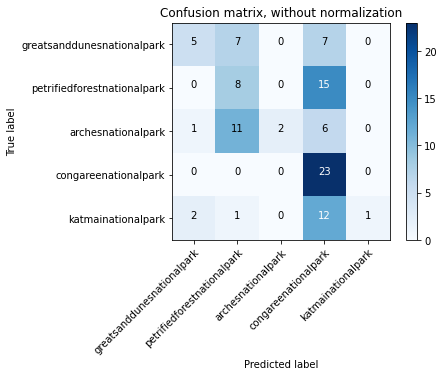

In [20]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_labels, pred_lab[:, 0])
label_set = np.unique(test_labels)
plot_confusion_matrix(cnf_matrix, [label_names[i].decode() for i in label_set],
                      title='Confusion matrix, without normalization')

In [21]:
import matplotlib.image as mpimg
def gen_err_predicted_fig( test_labels, pred_lab, label_set, label_names, 
                           test_sample_ids, srcPath='images_5_classes', 
                          figsize=(10, 10)):
    errNameMap = {}
    maxErrNameMap = {}
    cnt = 0
    for lab in label_set:
        for plab in label_set:
            if lab == plab:
                continue
            else:
                cIdx = np.nonzero(test_labels==lab)[0]
                errIdx = cIdx[ np.nonzero(pred_lab[cIdx, 0]==plab)[0] ]
                errNameMap[(lab, plab)] = errIdx
                if len(errIdx) != 0:
                    errProb = np.max( pred_lab[errIdx, 1] )
                    errFIdx = errIdx[ np.argmax( pred_lab[errIdx, 1] ) ]
                    maxErrNameMap[(lab, plab)] = errFIdx
    title_font = {'fontname':'Arial', 'size':'16', 
                  'color':'black', 'weight':'bold'} 
    fig = plt.figure(figsize=figsize)
    for i in range(25):
        rIdx = i // 5
        cIdx = i % 5
        ax = plt.subplot(5, 5, i+1)
        if rIdx == 0:
            ax.xaxis.set_label_position('top') 
            ax.set_xlabel( label_names[int(label_set[cIdx])].decode('utf-8'), 
                           rotation=45, rotation_mode='anchor', ha = 'left' )
        if cIdx == 0:
            ax.yaxis.set_label_position('left')
            ax.set_ylabel( label_names[int(label_set[rIdx])].decode('utf-8'),  
                           rotation=45, rotation_mode='anchor', ha = 'right' )
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.subplots_adjust(wspace=0, hspace=0)
        if (label_set[rIdx], label_set[cIdx]) in maxErrNameMap:
            fIdx = maxErrNameMap[(label_set[rIdx], label_set[cIdx])]            
            folderName = label_names[test_labels[fIdx]]            
            fID = test_sample_ids[fIdx]
            img=mpimg.imread( srcPath + '/' + folderName.decode('utf-8') + '/' + \
                             fID.decode('utf-8') + '.jpg')    
            plt.imshow(img)  # The AxesGrid object work as a list of axes.
        else:
            plt.text(0.5, 0.5, cnf_matrix[rIdx, cIdx],
                     **title_font)
    
    plt.show()

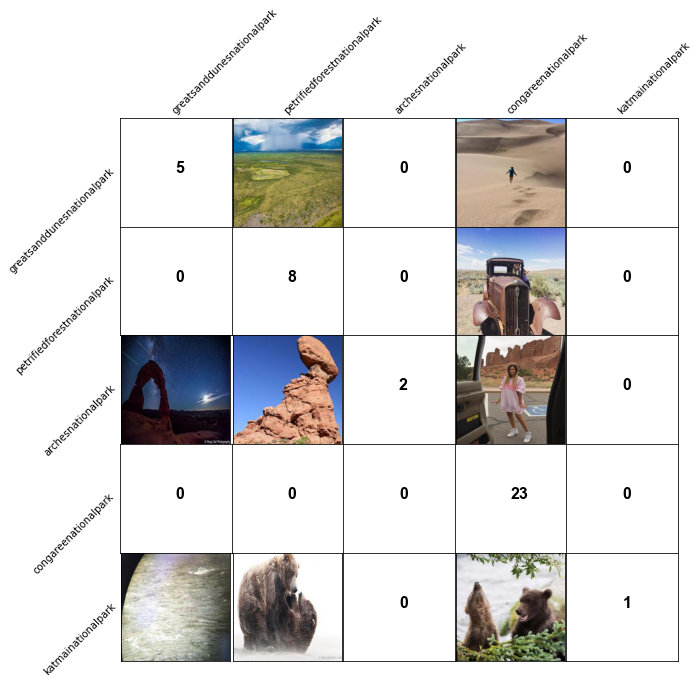

In [22]:
label_set = np.unique(test_labels)
gen_err_predicted_fig( test_labels, pred_lab, label_set, label_names, test_sample_ids)

<a href="#The-plan:">top</a>